In [7]:
# In[import all packages] :
"""
Pints and myokit should be installed before (follow instruction from Github)
"""

import numpy as np
import matplotlib.pyplot as plt
import pints
import myokit


# In[Initialization] :
"""
Call model from myokit 

"""

m = myokit.load_model('ThreeCompartment_IV_Model.mmt') #path for the model file 
p = myokit.load_protocol('protocol_New.mmt') #path for the protocol file(e.g. dose regimen)

ref = myokit.Simulation(m, p) #set up myokit model: input model and protocol 
save_state = ref.state()  #save the original initial state 

# Total  amount of drug dosed: 1mg/kg, 5mg/kg and 15mg/kg dose for mice (unit ng)
TotalDoseLevel= np.array([25000, 125000, 375000])

# Change DoseLevel to dosing per time unit
event_duration = p.events()[0].duration() # Extract duration of the dosing event from the protocol
DoseLevel = TotalDoseLevel / event_duration


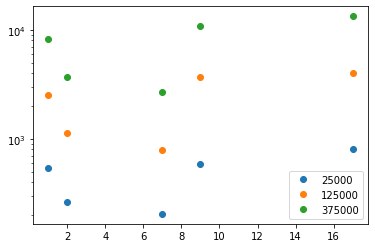

[[  538.77514605  2508.55767624  8283.21211856]
 [  262.14224187  1127.94491914  3688.04963215]
 [  204.48301451   793.71142433  2714.32197624]
 [  588.36854382  3662.8484028  10850.20910731]
 [  812.7449997   4044.27460194 13334.1599178 ]]


In [5]:
# In[Define Model]
"""
set up model compatible for pints, i.e. a class that takes parameters and
times        
"""
class MyokitModel(pints.ForwardModel):
    
    def __init__(self):
        m = myokit.load_model('ThreeCompartment_IV_Model.mmt') #path for the model file 
        p = myokit.load_protocol('protocol_New.mmt')#path for the protocol file(e.g. dose regimen)
      
        self.simulation = myokit.Simulation(m, p) #define simulation (i.e. run the model via myokit)

    def n_parameters(self):
        return 6 # number of parameters to Fit

    def simulate(self, parameters, times):
        Drug_Central = []
        
       #setting up simulation parameters 
        self.simulation.set_state(save_state)
        self.simulation.reset()     
        self.simulation.set_time(0)
        self.simulation.set_constant('AllCompartment.CL', parameters[0]) # define parameter 
        self.simulation.set_constant('AllCompartment.Vc', parameters[1]) # define parameter 
        self.simulation.set_constant('AllCompartment.Qp1', parameters[2]) # define parameter 
        self.simulation.set_constant('AllCompartment.Vp1', parameters[3]) # define parameter 
        self.simulation.set_constant('AllCompartment.Qp2', parameters[4]) # define parameter 
        self.simulation.set_constant('AllCompartment.Vp2', parameters[5]) # define parameter
                                 
        # simulating multiple dose levels
        var_to_log = 'AllCompartment.Drug_Concentration_Central'
        
        DoseAmounts=DoseLevel # Define dose level, can move this line to the initialization part 
        for i in range(len(DoseAmounts)):
            self.simulation.reset()  
            self.simulation.set_constant('dose.doseAmount', float(DoseAmounts[i]))
            Output = self.simulation.run(times[-1]+1, log=[var_to_log], log_times = times)
            Drug_Central.append(Output[var_to_log])
        
        return np.array(Drug_Central).T

# Then create an instance of our new model class
ThreeCompModel = MyokitModel()

# In[Run a test simulation]
param_test=[3,5,8,50,2,10] 

times= [1,2,7,9,17]

# run a test simulation
TestSimulation=ThreeCompModel.simulate(param_test ,times)
TestSimulation=np.asarray([v+ np.random.normal(0,0.1*v, v.shape) for v in TestSimulation])
# Plot the result
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i, trace in enumerate(TestSimulation.T):
    plt.plot(times, trace, 'o', label=TotalDoseLevel[i])
ax.set_yscale('log')
plt.legend()
plt.show()
#np.savetxt("results.csv", TestSimulation, delimiter=",")